# Assignment 1 first step on deep learning using tenserflow

In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# config the matplotlib backend as plotting inline in IPython
%matplotlib inline

1. get the notmnist dataset

In [6]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/home/student/project/project-01/nlp_bots/hw-xujing' # local data store directory

def download_progress_hook(count, blocksize, totalsize):
    """ A hook to report the progress of a download. This is mostly intended for users with slow
    internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blocksize * 100 / totalsize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and makesure it's the right size."""
    
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attemting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook= download_progress_hook)
        print('\ndownload complete')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified: ', dest_filename)
    else:
        raise Exception(
        'Failed to verify' + dest_filename + '. Can you get to it with a browser?')
        
    return dest_filename
    
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified:  /home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large.tar.gz
Found and verified:  /home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_small.tar.gz


In [7]:
num_class = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] #remove .tar.gz
    if os.path.isdir(root) and not force:
        print("%s is already present. Skipping extraction of %s." % (root, filename))
    else:
        print("Extracting data for %s. This may take a while please wait." % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    if len(data_folders) != num_class:
        raise Exception(
        "Expected %d folders, one per class. Found %d instead." % (
        num_class, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)        
test_folders = maybe_extract(test_filename)    

/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large is already present. Skipping extraction of /home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large.tar.gz.
['/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/A', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/B', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/C', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/D', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/E', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/F', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/G', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/H', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/I', '/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/J']
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_small is already present. Skippin

In [8]:
image_size = 28
pixel_depth = 255.0 # number of levels per pixel

def load_letter(folder, min_num_images):
    """load the data for a single data label."""
    image_files = os.listdir(folder)
    
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/A.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/B.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/C.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/D.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/E.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/F.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/G.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/H.pickle already present - Skipping pickling.
/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/I.pickle already present - Sk

Problem 1 plot images

In [9]:
np.ndarray(shape=(1, 2, 3), dtype=np.float32)

array([[[0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [10]:
#sample_file = '../picture/test.png'
#imageio.imread(sample_file).astype(float).shape #以数组形式读取图片

In [11]:
train_datasets[0]

'/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_large/A.pickle'

In [12]:
import random

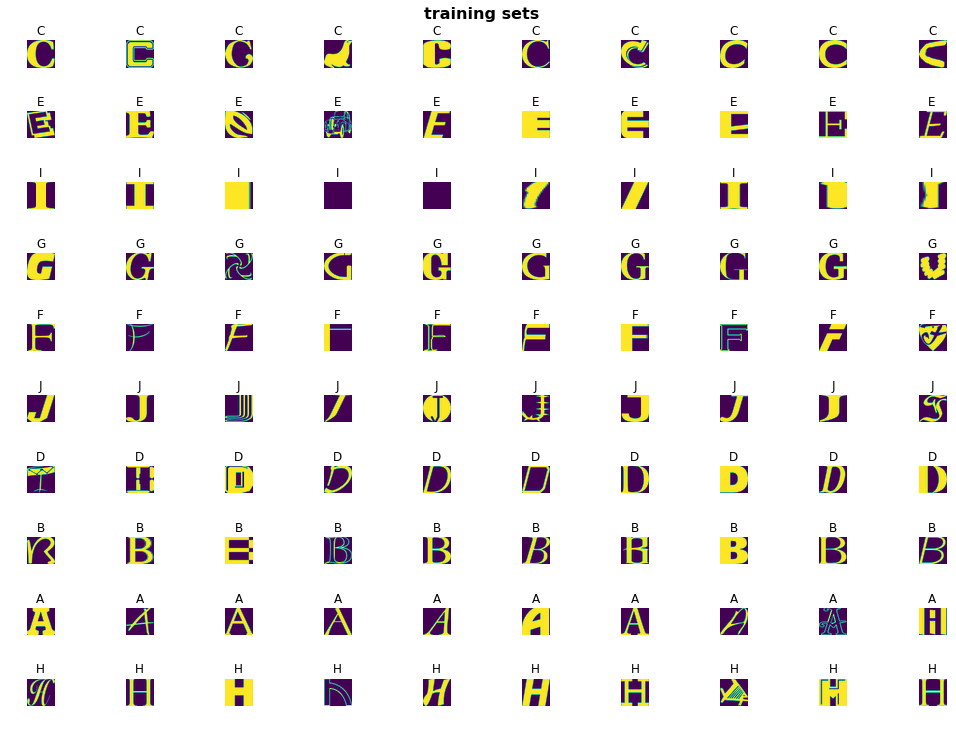

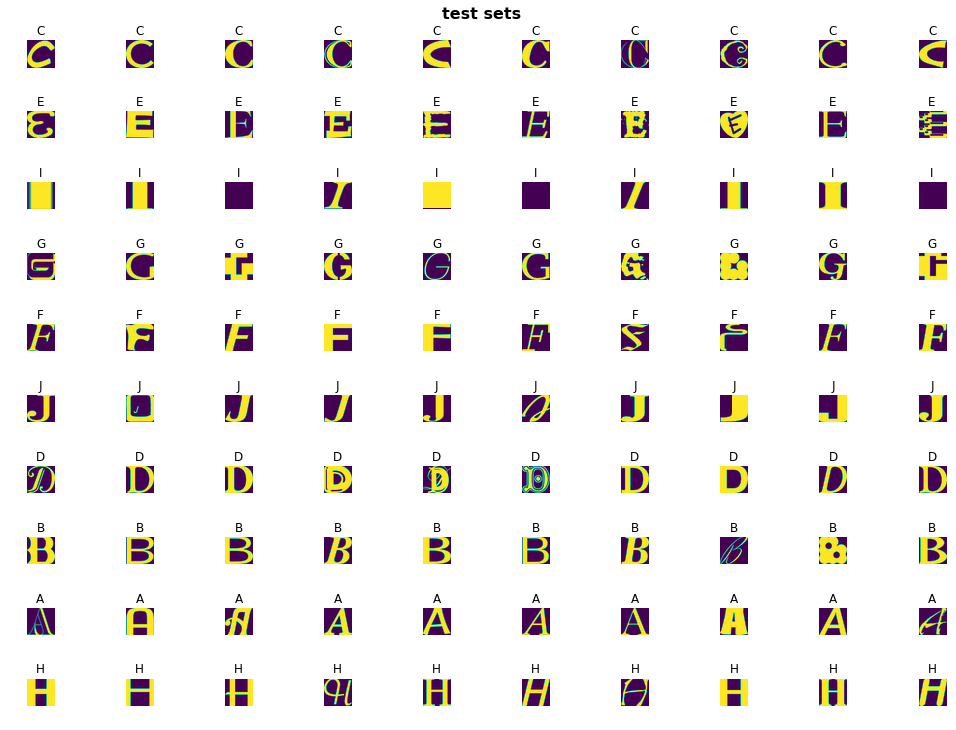

In [13]:
def plot_samples(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    data_root = '/home/student/project/project-01/nlp_bots/hw-xujing'
    path = os.path.join(data_root, path)
    i = 0
    for d in os.listdir(path):
        if d.endswith('.pickle'): continue
        image_path = os.path.join(path, d)
        image_files = random.sample(os.listdir(image_path), sample_size)
        for j, im in enumerate(image_files):
            im = imageio.imread(os.path.join(image_path, im))
            axes[i, j].imshow(im)
            axes[i, j].set_title(d)
            axes[i, j].set_axis_off()
        i += 1
    fig.tight_layout()
plot_samples('notMNIST_large', 10, 'training sets')
plot_samples('notMNIST_small', 10, 'test sets')

# problem 2 plot data_samples with pyplot

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

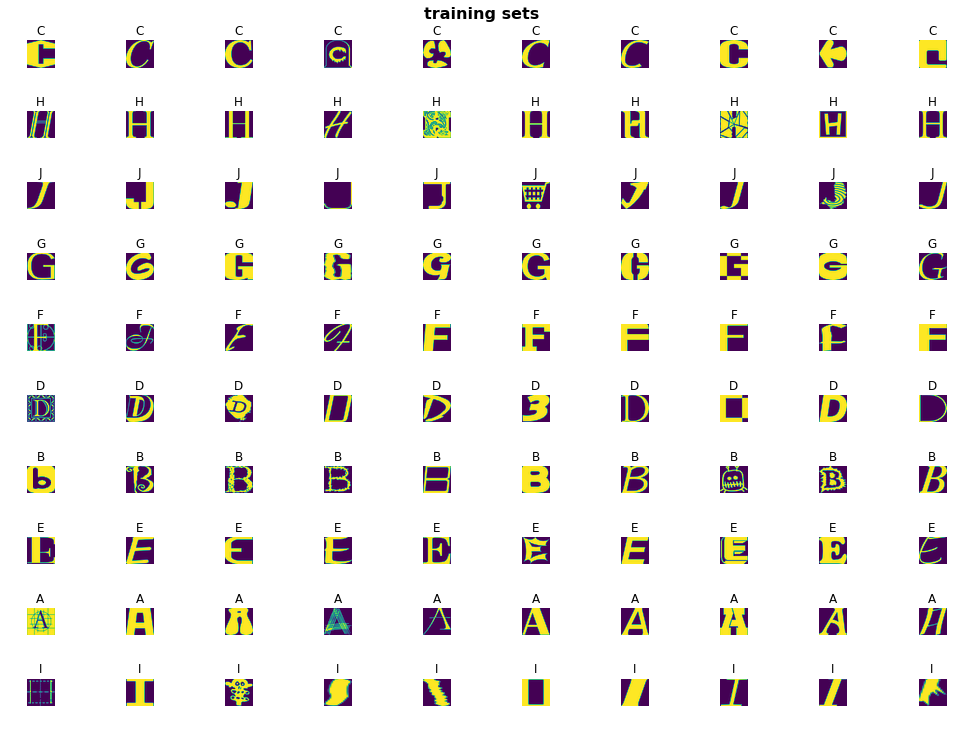

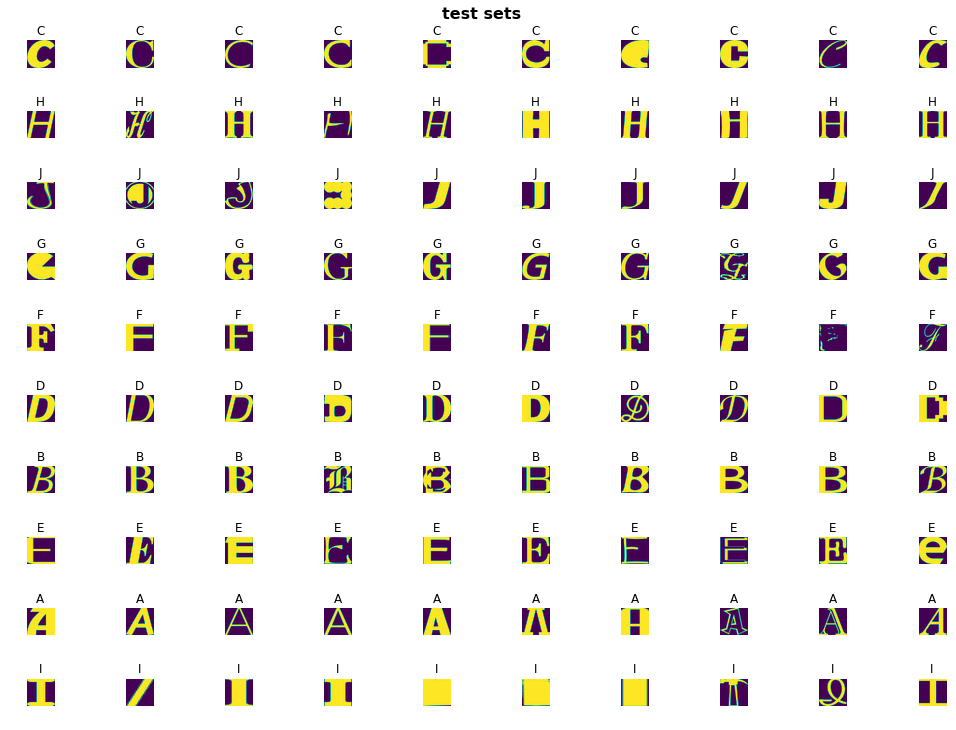

In [15]:
def plot_samples_from_ndarray(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    path = os.path.join('/home/student/project/project-01/nlp_bots/hw-xujing', path)
    i = 0
    class_nums = []
    for d in os.listdir(path):
        if d.endswith('.pickle'):
            image_path = os.path.join(path, d)
            with open(image_path, 'rb') as f:
                all_images = pickle.load(f)
            class_nums.append((d[:-7], all_images.shape[0]))
            image_files = random.sample(list(all_images), sample_size)
            for j, im in enumerate(image_files):
                axes[i, j].imshow(im)
                axes[i, j].set_title(d[:-7])
                axes[i, j].set_axis_off()
            i += 1
    fig.tight_layout()
    return class_nums
training_class_nums = plot_samples_from_ndarray('notMNIST_large', 10, 'training sets')
test_class_nums = plot_samples_from_ndarray('notMNIST_small', 10, 'test sets')

# problem 3

another check: verify if data is balanced or not

In [16]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

#每个类别选取相同数量额训练数据和验证数据
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    image_size = 28
    
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)#初始化验证集
    train_dataset, train_labels = make_arrays(train_size, image_size)#初始化训练集
    vsize_per_class = valid_size // num_classes ##使得每个类别的样本数一致
    tsize_per_class = train_size // num_classes ##使得每个类别的样本数一致

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]#
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
    
    return valid_dataset, valid_labels, train_dataset, train_labels
    
        

In [17]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


next, randomized the trainingdata and test data

In [18]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [19]:
train_dataset[0], train_labels[0]

(array([[ 0.43333334, -0.12352941, -0.09215686, -0.1       , -0.1       ,
         -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
         -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
         -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
         -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ,
         -0.09215686, -0.12352941,  0.43333334],
        [ 0.38627452, -0.5       , -0.4882353 , -0.5       , -0.5       ,
         -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.4882353 , -0.5       ,  0.38627452],
        [ 0.39019608, -0.5       , -0.4764706 , -0.4882353 , -0.4882353 ,
         -0.4882353 , -0.4882353 , -0.4882353 , -0.4882353 , -0.4882353 ,
         -0.48

# problem 4 check data is still good

save data for later reuse

In [20]:
data_root = '/home/student/project/project-01/nlp_bots/hw-xujing'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
print(pickle_file)
try:
    with open(pickle_file, 'wb') as f:
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST.pickle


In [21]:
statinfo = os.stat(pickle_file)
print('Compress pickle size:', statinfo.st_size)

Compress pickle size: 690800506


# problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.


Optional questions:

.What about near duplicates between datasets? (images that are almost identical)
.Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

对比两图片矩阵是否绝对相等

In [23]:
from collections import defaultdict
##提取出dataset1和dataset2中一样的图片，返回（索引：索引）的字典
def extract_overlap(dataset1, dataset2):
    overlap = defaultdict(list)
    for i, imgi in enumerate(dataset1):
        for j,imgj in enumerate(dataset2):
            if np.array_equal(imgi, imgj):
                overlap[i] += [j]
    return overlap


##从target_dataset中选取前8个与source_dataset某一与的图片相似的图片，
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item)
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

In [24]:
overlap_dict = extract_overlap(test_dataset[:50],train_dataset)

Number of overlaps: 8


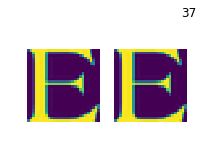

In [25]:
print('Number of overlaps:', len(overlap_dict.keys()))
display_overlap(overlap_dict,test_dataset[:50],train_dataset)

using hash function to improve computing speed

In [24]:
import hashlib
MAX_NORM = 10
def delete_overlap_hash(dataset1, dataset2, labels1):
    overlap = []
    #hashlib.sha256(img).hexdigest()是一种hash函数，它把根据数据生成一段256位的信息摘要
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2])
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i) 
    return np.delete(dataset1, overlap, 0), np.delete(labels1, overlap)

Number of overlaps: 27


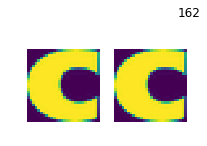

In [29]:
overlap_dict_hash = extract_overlap_hash(test_dataset[:200], train_dataset)
print('Number of overlaps:', len(overlap_dict_hash_where.keys()))
display_overlap(overlap_dict_hash, test_dataset[:200], train_dataset)

用哈希矩阵计算更快， 因此只用哈希找出所有重复数据

In [27]:
test_data_sani, test_labels_sani = delete_overlap_hash(test_dataset, train_dataset, test_labels)
print('removed images', len(test_dataset) - len(test_data_sani))

removed images 1309


In [28]:
valid_data_sani, valid_labels_sani = delete_overlap_hash(valid_dataset, train_dataset, valid_labels)
print('removed images', len(valid_dataset) -len(valid_data_sani))

removed images 1053


In [30]:
data_root = '/home/student/project/project-01/nlp_bots/hw-xujing'
pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')
print(pickle_file)
try:
    with open(pickle_file, 'wb') as f:
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_data_sani,
        'valid_labels': valid_labels_sani,
        'test_dataset': test_data_sani,
        'test_labels': test_labels_sani,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

/home/student/project/project-01/nlp_bots/hw-xujing/notMNIST_clean.pickle


# Problem 6 

LogisticRegression with data got above

In [31]:
from sklearn.linear_model import LogisticRegression

In [33]:
lr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28*28)
y_test = test_labels

In [ ]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape


